The beta-geometric (BG) distribution is a robust simple model for characterizing and forecasting the length of a customer's relationship with a firm in a contractual setting.

**Source**:
- [A Spreadsheet-Literate Non-Statistician's Guide to the Beta-Geometric Model](http://www.brucehardie.com/notes/032/)
- [Customer-Base Valuation in a Contractual Setting: The Perils of Ignoring Heterogeneity](https://brucehardie.com/papers/022/)
- [How to Project Customer Retention](http://www.brucehardie.com/papers/021/)
- [How Not to Project Customer Retention](https://brucehardie.com/notes/016/)
- [Computing DERL for the sBG Model Using Excel](https://brucehardie.com/notes/018/)

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import beta
from scipy.special import hyp2f1
import polars as pl

import matplotlib.pyplot as plt
import matplotlib_inline
from IPython.display import display_markdown
from great_tables import GT

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [2]:
year, alive = np.loadtxt('data/hardie-sample-retention.csv', dtype='object', delimiter=',', unpack=True, skiprows=1) 
year = year.astype(int)
alive = alive.astype(float)

train_period = 4
train_year = year[:train_period+1]
train_alive = alive[:train_period+1]

In [3]:
def bg_param(year, alive):
    actual_retention = alive[1:] / alive[:-1]
    def SSE(x):
        gamma, delta = x[0], x[1]
        est_retention = (delta+year[1:]-1)/(gamma+delta+year[1:]-1)
        return np.sum((actual_retention - est_retention)**2)
    return minimize(SSE, x0=[0.1,0.1], bounds=[(0, np.inf), (0, np.inf)])

res = bg_param(train_year, train_alive)
gamma, delta = res.x
SSE = res.fun

display_markdown(f'''$\\gamma$ = {gamma:0.4f}

$\\delta$ = {delta:0.4f}

Sum of Squared Errors = {SSE:0.4E}''', raw=True)

$\gamma$ = 0.7597

$\delta$ = 1.2862

Sum of Squared Errors = 1.1645E-04

In [4]:
act_retention_rate = alive[1:] / alive[:-1]

est_retention_rate = (delta+year[1:]-1)/(gamma+delta+year[1:]-1)
est_survivor_function = np.ones(year.shape)
est_survivor_function[1:] = est_retention_rate
est_survivor_function = np.cumprod(est_survivor_function)
est_survivors = est_survivor_function * alive[0]

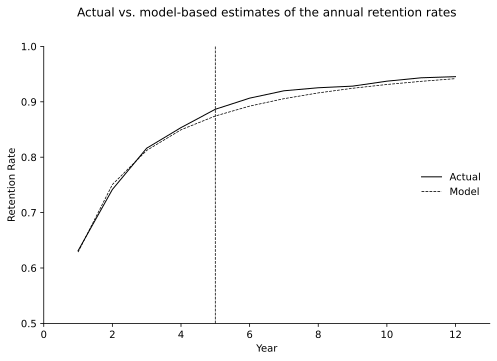

In [9]:
plt.figure(figsize=(8,5), dpi=100)
plt.plot(year[1:], act_retention_rate, "k-", linewidth=1, label='Actual')
plt.plot(year[1:], est_retention_rate, "k--", linewidth=0.75, label='Model')
plt.axvline(5, color="black", linestyle='--', linewidth=0.75)
plt.xlabel("Year")
plt.ylabel("Retention Rate")
plt.title('Actual vs. model-based estimates of the annual retention rates', pad=30)
plt.ylim(0.5,1)
plt.xlim(0, 13)
plt.legend(loc=7, frameon=False);

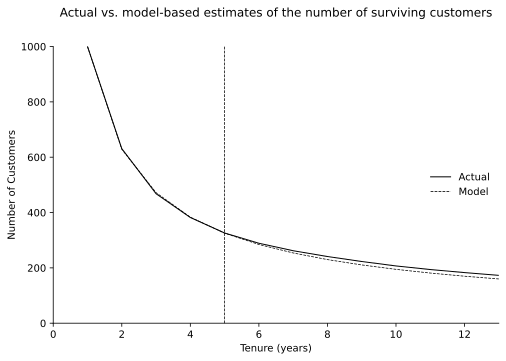

In [11]:
plt.figure(figsize=(8,5), dpi=100)
plt.plot(year+1, alive, "k-", linewidth=1, label='Actual')
plt.plot(year+1, est_survivors, "k--", linewidth=0.75, label='Model')
plt.axvline(5, color="black", linestyle='--', linewidth=0.75)
plt.xlabel("Tenure (years)")
plt.ylabel("Number of Customers")
plt.title('Actual vs. model-based estimates of the number of surviving customers', pad=30)
plt.ylim(0,1000)
plt.xlim(0, 13)
plt.legend(loc=7, frameon=False);

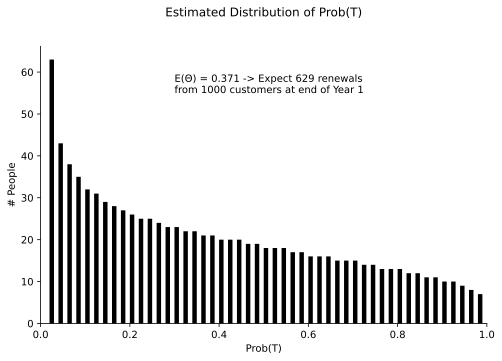

In [7]:
e_churn = gamma / (gamma + delta) # E(Θ) - Expected number of churn next period
e_renewals = alive[0] - e_churn
alive_t0 = (1 - e_churn) * alive[0]

x = np.arange(0,1.02,0.02)
y = np.around(np.diff(beta.cdf(x, gamma, delta)) * alive[0])
plt.figure(figsize=(8,5), dpi=100)
plt.bar(x[1:], y, align="edge", width=0.01, color="black")
plt.xlim(0, 1)
plt.xlabel('Prob(T)')
plt.ylabel('# People')
plt.title('Estimated Distribution of Prob(T)', pad=30)
plt.text(x=0.3, y=55 , s=f'E(Θ) = {e_churn:0.3f} -> Expect {alive_t0:.0f} renewals\nfrom {alive[0]:.0f} customers at end of Year 1', fontsize=10);

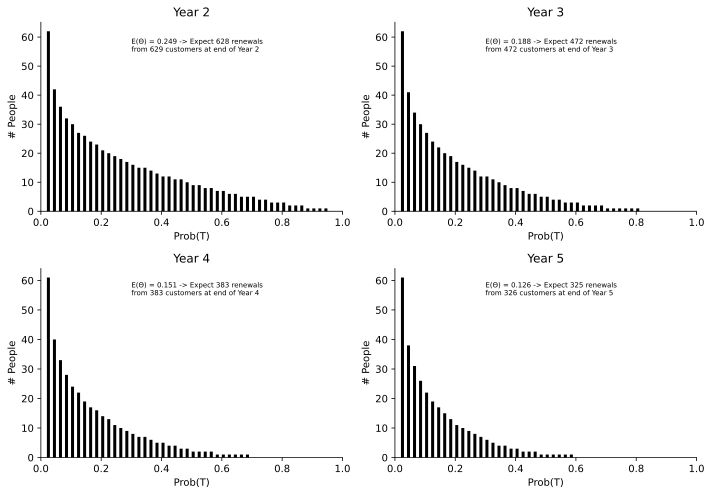

In [8]:
renewals = 4
x = np.arange(0,1.02,0.02)

fig, axes = plt.subplots(2, 2, figsize=(10, 7), dpi=200)
for n in range(renewals):
    alive_t0 = est_survivors[n+1]
    y = np.around(np.diff(beta.cdf(x, gamma, delta + n + 1)) * alive_t0)
    e_churn = gamma / (gamma + delta + n + 1)
    e_renewals = alive_t0 - e_churn
    ax = axes[n // 2][n % 2]
    
    ax.bar(x[1:], y, align="edge", width=0.01, color="black")
    ax.set_xlim(0, 1)
    ax.set_xlabel('Prob(T)')
    ax.set_ylabel('# People')
    ax.set_title(f'Year {n+2}')
    ax.text(x=0.3, y=55 , s=f'E(Θ) = {e_churn:0.3f} -> Expect {e_renewals:.0f} renewals\nfrom {alive_t0:.0f} customers at end of Year {n+2}', fontsize=7)
    ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.show()

Working with Multi-Cohort Data

---

In [58]:
#  Number of Active Customers Each Year by Year-of-Acquisition Cohort
columns = ['Cohort 1', 'Cohort 2', 'Cohort 3', 'Cohort 4', 'Cohort 5']
cohort_data = pl.read_csv('data/contractual-setting-multi-cohort-data.csv').with_columns(pl.sum_horizontal(columns).alias('Total'))

(
    GT(cohort_data, rowname_col='Year')
    .fmt_integer(columns=columns+['Total'], sep_mark=',')
    .sub_missing(columns=columns+['Total'], missing_text='')
    .tab_header(title='Number of Active Customers Each Year by Year-of-Acquisition Cohort')
    .tab_stubhead('Year')
    .opt_stylize(style=1, color='gray')
)

GT(_tbl_data=shape: (5, 7)
┌──────┬──────────┬──────────┬──────────┬──────────┬──────────┬───────┐
│ Year ┆ Cohort 1 ┆ Cohort 2 ┆ Cohort 3 ┆ Cohort 4 ┆ Cohort 5 ┆ Total │
│ ---  ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---   │
│ i64  ┆ i64      ┆ i64      ┆ i64      ┆ i64      ┆ i64      ┆ i64   │
╞══════╪══════════╪══════════╪══════════╪══════════╪══════════╪═══════╡
│ 2003 ┆ 10000    ┆ null     ┆ null     ┆ null     ┆ null     ┆ 10000 │
│ 2004 ┆ 6334     ┆ 10000    ┆ null     ┆ null     ┆ null     ┆ 16334 │
│ 2005 ┆ 4367     ┆ 6334     ┆ 10000    ┆ null     ┆ null     ┆ 20701 │
│ 2006 ┆ 3264     ┆ 4367     ┆ 6334     ┆ 10000    ┆ null     ┆ 23965 │
│ 2007 ┆ 2604     ┆ 3264     ┆ 4367     ┆ 6334     ┆ 10000    ┆ 26569 │
└──────┴──────────┴──────────┴──────────┴──────────┴──────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x000001F2CE166E70>, _boxhead=Boxhead([ColInfo(var='Year', type=<ColInfoTypeEnum.stub: 2>, column_label='Year', column_align='right', column_width=None), ColInfo(var='Cohort 1', type=<ColInfoTypeEnum.default: 1>, column_label='Cohort 1', column_align='right', column_width=None), ColInfo(var='Cohort 2', type=<ColInfoTypeEnum.default: 1>, column_label='Cohort 2', column_align='right', column_width=None), ColInfo(var='Cohort 3', type=<ColInfoTypeEnum.default: 1>, column_label='Cohort 3', column_align='right', column_width=None), ColInfo(var='Cohort 4', type=<ColInfoTypeEnum.default: 1>, column_label='Cohort 4', column_align='right', column_width=None), ColInfo(var='Cohort 5', type=<ColInfoTypeEnum.default: 1>, column_label='Cohort 5', column_align='right', column_width=None), ColInfo(var='Total', type=<ColInfoTypeEnum.default: 1>, column_label='Total', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001F2CE1A6C00>, _spanners=Spanners([]), _heading=Heading(title='Number of Active Customers Each Year by Year-of-Acquisition Cohort', subtitle=None, preheader=None), _stubhead='Year', _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000001F2CE1A51F0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000001F2CE1A5AF0>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x000001F2CE1A5B20>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='t

In [69]:
# Annual Retention Rates by Cohort
cohort_annual_retention = cohort_data.drop('Total').with_columns(pl.col('*').exclude('Year').pct_change() + 1)

(
    GT(cohort_annual_retention, rowname_col='Year')
    .fmt_number(columns=columns, decimals=3)
    .sub_missing(columns=columns, missing_text='')
    .tab_header(title='Annual Retention Rates by Cohort')
    .tab_stubhead('Year')
    .opt_stylize(style=1, color='gray')
)

GT(_tbl_data=shape: (5, 6)
┌──────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ Year ┆ Cohort 1 ┆ Cohort 2 ┆ Cohort 3 ┆ Cohort 4 ┆ Cohort 5 │
│ ---  ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i64  ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 2003 ┆ null     ┆ null     ┆ null     ┆ null     ┆ null     │
│ 2004 ┆ 0.6334   ┆ null     ┆ null     ┆ null     ┆ null     │
│ 2005 ┆ 0.689454 ┆ 0.6334   ┆ null     ┆ null     ┆ null     │
│ 2006 ┆ 0.747424 ┆ 0.689454 ┆ 0.6334   ┆ null     ┆ null     │
│ 2007 ┆ 0.797794 ┆ 0.747424 ┆ 0.689454 ┆ 0.6334   ┆ null     │
└──────┴──────────┴──────────┴──────────┴──────────┴──────────┘, _body=<great_tables._gt_data.Body object at 0x000001F2CE2400E0>, _boxhead=Boxhead([ColInfo(var='Year', type=<ColInfoTypeEnum.stub: 2>, column_label='Year', column_align='right', column_width=None), ColInfo(var='Cohort 1', type=<ColInfoTypeEnum.default: 1>, column_label='Cohort 1', column_align='right', column_width=None), ColInfo(var='Cohort 2', type=<ColInfoTypeEnum.default: 1>, column_label='Cohort 2', column_align='right', column_width=None), ColInfo(var='Cohort 3', type=<ColInfoTypeEnum.default: 1>, column_label='Cohort 3', column_align='right', column_width=None), ColInfo(var='Cohort 4', type=<ColInfoTypeEnum.default: 1>, column_label='Cohort 4', column_align='right', column_width=None), ColInfo(var='Cohort 5', type=<ColInfoTypeEnum.default: 1>, column_label='Cohort 5', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001F2CE1EA180>, _spanners=Spanners([]), _heading=Heading(title='Annual Retention Rates by Cohort', subtitle=None, preheader=None), _stubhead='Year', _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000001F2CE1F8A40>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000001F2CE1F9040>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x000001F2CE1F9280>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#000000'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_righ

Computing CLV under the sBG Model

In [ ]:
# DEL - Discounted Expected Lifetime: Expected Discounted Lifetime E(DL) 
def sbg_del(gamma, delta, d):
    return hyp2f1(1, delta, gamma + delta, 1/(1+d))

# DERL - Discounted Expected Residual Lifetime: Expected Discounted Residual Lifetime E(DRL) 
def sbg_drl(gamma, delta, n, d, mode=1):
    '''
    mode 1: discounted expected residual lifetime of a just-acquired customer (equals DEL(d)−1, since it does not count the first-ever purchase by the customer)
    mode 2: Standing at the end of period n, just prior to the point in time at which the contract renewal decision is made (i.e., the customer has renewed his 
            contract n − 1 times and we have yet to learn whether or not the nth contract renewal will be made); just before the point in time at which the 
            contract renewal decision is made
    mode 3: The discounted expected residual lifetime of a customer evaluated immediately after we have received the payment associated with her nth contract renewal
    '''
    if mode == 1:
        return delta / ((gamma + delta) * (1 + d)) * hyp2f1(1, delta + 1, gamma + delta + 1, 1/(1+d))
    if mode == 2:
        return (delta + n - 1)/(gamma + delta + n - 1) * hyp2f1(1, delta + n, gamma + delta + n, 1/(1+d))
    if mode == 3:
        return (delta + n)/((gamma + delta + n)*(1+d)) * hyp2f1(1, delta + n + 1, gamma + delta + n + 1, 1/(1+d))